# A Fail-Safe Maximum Criticality Policy

In [1]:
import numpy as np

from domoku.tools import GomokuTools as gt
from domoku.data import create_binary_rep
from domoku.board import GomokuBoard
from domoku.policies import maximal_criticality as mc

import tensorflow as tf

## Constant filters

We provide a factory class that creates initializers for various convolutional filters to be used in policies. Note that this is different from detectors that identify the mere existence.

Our filters identify the field that exploits the pattern.

---

### Smoke Test
#### Sure win = the pattern allows the current player to win with the next move.
All non-zero filter params are on the first channel
All zero filter params are on the second channel (observe the occupation penalty!)

In [2]:
input_size = 7

The policy has 5 t1 and 4 t2 patterns, each of which comes in any of the two channels, i. e. we have a total of 9x2 patterns.

In [3]:
policy = mc.MaxCriticalityPolicy(input_size)
patterns = policy.select_patterns()
len(patterns)

2022-05-24 18:02:05.811184: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


60

In [4]:
filters, _, _ = policy.assemble_filters()

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [6]:
filters.shape

(11, 11, 2, 240)

In [7]:
print(filters[:, :, 0, 0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


This is a rotation-invariant filter set that represents a particular pattern '...XX.XX...' anywhere on the board

In [5]:
filters, biases, weights = policy.assemble_filters()

In [6]:
index = 41
gt.print_bin(filters[:,:,:,index])
print(weights[index])
print(biases[index])

shape: (11, 11, 2)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  

## MaxCriticalityPolicy

This policy will always propose the field with highest criticality

### Test it on a real board

In [7]:
SIZE=7

In [8]:
def suggest_greedy(sample):
    res = policy(sample)
    vec = tf.reshape(res, (1, -1))
    pos = tf.squeeze(tf.argmax(vec, axis=1))
    y = pos // SIZE
    x = pos - y * SIZE
    bx, by = gt.m2b((y, x), size=SIZE)
    return chr(64 + bx) + str(by)

In [9]:
samples = {
    'b1c5d3e3e4f2c3d4': 'B6',
    'b1c5d3e3e4f2c2d5': 'F5',
}
examine = 'b1c5d3e3e4f2c3d4'

#### Verify the policy output

(1, 7, 7, 1)
(7, 7, 2)
(11, 11, 2, 240)
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 50.]]
B6
(1, 7, 7, 1)
(7, 7, 2)
(11, 11, 2, 240)
All good. Congrats!!!


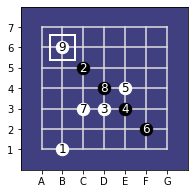

In [10]:
for b, move in samples.items():
    stones = gt.string_to_stones(b)
    board = GomokuBoard(n=SIZE, disp_width=3, stones=stones)
    sample = create_binary_rep(board.N, board.stones, board.current_color)
    board.set(*gt.string_to_stones(move)[0])
    res = policy(sample)
    print(res.shape)
    print(sample.shape)
    print(policy.assemble_filters()[0].shape)
    suggested = suggest_greedy(sample)
    assert(move == suggested)
    if b == examine:
        board.display()
        print(np.squeeze(res.numpy()))
        print(suggested)
print("All good. Congrats!!!")

In [12]:
b = 'c3e3c4e4c5e5'

[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   1. 100.   0.]
 [  0.   0.   0.   5.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.]]
F5


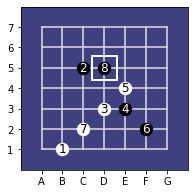

In [14]:
stones = gt.string_to_stones(b)
board = GomokuBoard(n=SIZE, disp_width=3, stones=stones)
sample = create_binary_rep(board.N, board.stones, board.current_color)
res = policy(sample)
print(np.squeeze(res.numpy()))
suggested = suggest_greedy(sample)
board.display()
print(suggested)